# OpenCV & Mediapipe 的手势识别

参考：[dirkzon/gesture-recognition: Real time gesture recognition using OpenCV & Mediapipe](https://github.com/dirkzon/gesture-recognition)

这个笔记本的目的是尝试创建一个可以从图像中识别手势的机器学习模型。为了识别手的姿态，使用 OpenCV 的 OpenPose 模型。这个模型将返回一些在手上预定（predetermined）的点。然后我们可以训练一个模型将这些点分类成一些手势意义。该方法分离了识别手的关注点，并对点进行分类。

![Knipsel.PNG](logo/Knipsel.png)

In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

下面我们可以看到一个手语手势的例子。这个手势的标签是“3”。

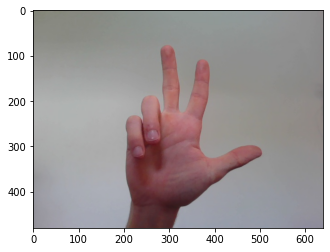

In [3]:
frame = cv2.imread("../test_images/3.jpg")
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

## 载入模型

使用 [OpenCV](https://opencv.org/) 处理所有图像。加上预先训练的 [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) 模型，便可以识别手势。要使用这个模型，我们需要两个东西：模型本身和一个 `'.prototxt'` 文件。这两个文件都应该放在 `../openpose` 目录中。'`pose_deploy.prototxt`' 已经放在在这个目录里，但是模型没有，需要去[下载](https://www.kaggle.com/changethetuneman/openpose-model?select=pose_iter_102000.caffemodel)。下载模型后，可以在 OpenCV 中加载这两个文件。使用 OpenCV 而不是 Mediapipe 来处理手的原因是 `openpose` 模型更适合低分辨率的图像，也更灵活。使用 OpenCV 的一个缺点是它比 `medipipe` 模型慢得多。但这并不重要，因为我们只需要处理图像一次。

In [4]:
protoFile = "../openpose/pose_deploy.prototxt"
weightsFile = "../openpose/pose_iter_102000.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

## 预测

OpenPose 模型通过识别手上的特定点来发挥作用。模型的输入是一个 blob，一个 blob 表示图像中像素的连接区域。可以将这个 blob 传递给 `OpenPose` 模型。得到了一个概率映射的列表。

In [5]:
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
aspect_ratio = frameWidth/frameHeight
threshold = 0.1

# 为网络输入图像尺寸
inHeight = 368
inWidth = int(((aspect_ratio*inHeight)*8)//8)
# 转换图片为 blob
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

# 从 openpose 模型获得输出
output = net.forward()

下面的图片是这些概率图的例子。有亮像素的区域是模型预测的手上的某个点。手和手指上的这些点是由 `OpenPose` 模型定义的。

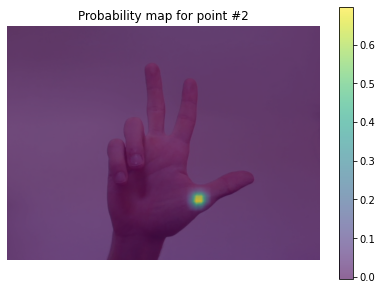

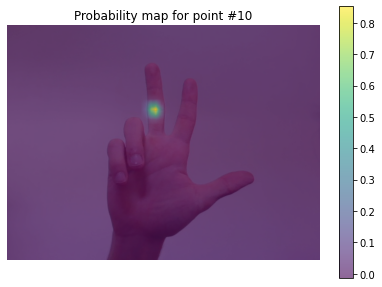

In [6]:
for i in [2, 10]:
    probMap = output[0, i, :, :]
    probMap = cv2.resize(probMap, (frame.shape[1], frame.shape[0]))
    plt.figure(figsize=[7,5])
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.imshow(probMap, alpha=0.6)
    plt.colorbar()
    plt.title(f'Probability map for point #{i}')
    plt.axis("off")
plt.show()

## 获取点

模型中，总共返回 21 个概率图。现在可以遍历这些映射来提取这些点。能得到的点数是 21。手的底部有一个点，每根手指有 4 个点。这些点应该总是在手掌的相同位置。但是，如果概率图中的区域低于阈值，它将不会被包括在内，因为它很可能不是非常准确。总共有 42 个不同的值，因为每个点都有一个  `x` 和 `y` 值。这些值将用于训练出手势识别模型。

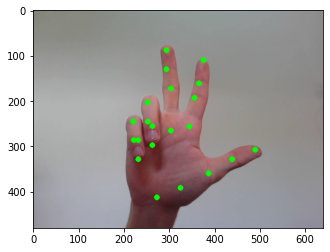

In [7]:
for i in range(21):
    # get confidence map of hand
    probMap = output[0, i, ...]
    probMap = cv2.resize(probMap, (frameWidth, frameHeight))

    # Find maxima of the confidence map
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # draw point if probabilty is greater than theshold
    if prob > 0.1 :
        cv2.circle(frameCopy, (int(point[0]), int(point[1])), 6, (0, 255, 0), thickness=-1, lineType=cv2.FILLED)
        
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
plt.show()

## 图像处理

### 数据集

现在我们知道了如何处理一个图像，我们可以从处理数据集开始。我们将使用的数据集是不包含在这个存储库中。数据集可以下载[这里](https://github.com/ardamavi/Sign-Language-Digits-Dataset)。并且应该放在根目录中的一个名为 `draft` 的目录中。数据集的每个子文件夹都应该放在这个 `draft` 目录中。生成如下所示的根文件夹。`draft` 文件夹应该包含每个手势的子文件夹。这些文件夹里有对应的图片。

. <br>
├─ 🗋 docs/gesture-recognition.ipynb <br>
├─ 🗁 draft/ <br>
│  ├─🗀 0/ <br>
│  ├─🗀 1/ <br>
│  ├─🗀 2/ <br>
│  ├─🗀 4/ <br>
│  ├─🗀 5/ <br>
│  ├─🗀 6/ <br>
│  ├─🗀 7/ <br>
│  ├─🗀 8/ <br>
│  ├─🗀 9/ <br>
├─🗀 test_images/ <br>
├─...


每个子文件夹的名称是手势的标签。每个手势大约有 200 张图片。这些图像是不同种类的手在不同的照明条件。所有图像都是 100 × 100 像素。

>*Mavi, A., (2020), “A New Dataset and Proposed Convolutional Neural Network Architecture for Classification of American Sign Language Digits”, arXiv:2011.08927 [cs.CV]*

### 处理

现在可以开始处理数据集了。可以看到三种方法。每个方法负责流程中的不同步骤。总之，我们只是循环遍历了 `draft` 目录中的每个子文件夹。然后逐个处理图像，并将这些点添加到一个数组中。

下面的方法负责从 OpenPose 模型的输出中获取点。

In [8]:
def get_points(nPoints, net_output, shape, threshold):
    output_points = []
    
    for i in range(nPoints):
        # get confidence map of hand
        probMap = net_output[0, i, ...]
        probMap = cv2.resize(probMap, shape)
        
        # Find maxima of the confidence map
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        
        # append point if probabilty is greater than theshold
        if prob > threshold:
            output_points.append(int(point[0]))
            output_points.append(int(point[1]))
        else:
            output_points.append(None)
            output_points.append(None)
            
    return output_points

下面的方法负责将图像转换为一个 blob，并将这个 blob 传递给 OpenPose 模型。然后使用 `get_points` 方法获取点数。最后把这个手势加到 `arary` 中。

In [9]:
def process_image(frame):
    # input image dimensions for the network
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    inHeight = 368
    inWidth = int(((frameWidth/frameHeight*inHeight)*8)//8)
    
    #transform image into blob
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                      (0, 0, 0), swapRB=False, crop=False)
    
    # get output from openpose model
    net.setInput(inpBlob)
    output = net.forward()
    
    # get points out of output
    return get_points(21, output, (frameWidth,frameHeight), 0.1)

为了处理数据集中的所有图像，我们可以遍历“数字手势”文件夹中的所有文件夹。然后循环遍历这些文件夹中的所有图像。使用'`process_image`'方法，逐个处理这些图像。将输出数组添加到 `array` 中。

In [10]:
from IPython.display import clear_output
import os

folder = '../draft'

array = []

# iterate through all folders
for subfolder in os.listdir(folder):
    sub = folder +'/'+ subfolder
    subfolder_size = len(os.listdir(sub))
    i = 0
    # iterate through all subfolders
    for file in os.listdir(sub):
        frame = cv2.imread(sub + '/' + file)
        points = process_image(frame)
        points_gesture = np.append(points, subfolder, axis=None)
        array.append(points_gesture)
        print("processing: " + subfolder)
        i += 1
        print((i/subfolder_size) * 100, '%')
        clear_output(wait=True)

processing: 9
100.0 %


### 创建 dataframe

在处理所有图像后，该阵列可以转换为一个 dataframe。前 42 列是点是位置。例如，列'0'和'1'表示第一个点，'3'和'4'表示第二个点，等等。最后一栏是手势的含义

In [33]:
processed = pd.DataFrame(array)
# 将最后一列重命名为“gesture”
processed = processed.rename(columns={processed.columns[-1]:"gesture"})
processed.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,gesture
0,66,70,55,64,44,53,39,44,35,38,...,46,62,39,53,39,48,42,48,46,0
1,52,76,57,61,59,46,62,31,59,23,...,28,42,47,44,26,51,22,55,29,0
2,55,83,51,72,46,58,None,None,None,None,...,25,57,53,59,40,59,31,60,31,0
3,51,88,46,75,None,None,None,None,None,None,...,29,45,44,50,24,57,21,64,29,0
4,31,81,None,None,None,None,70,33,73,29,...,35,40,37,55,29,63,33,68,39,0


最后，可以将数据帧保存为'.csv'文件。因此，可以在未来再次使用数据，而不必再次处理整个数据集。

In [34]:
processed.to_csv('../dataframes/gesture-points-raw.csv', index=None)

In [35]:
processed = pd.read_csv('../dataframes/gesture-points-raw.csv')

## 预处理

现在有了处理所有图像的点数据，可以开始清理和处理数据集。

### 修复 none 值

首先，我们可以看到数据帧中有很多 `none` 值。所以，首先必须修正它。如果查看丢失的单元格数量，则每一列都有一些丢失的值。但是不存在所有值都缺失的列。这意味着将能够使用这些不缺失的值来修复缺失的值。修复这些值的一种方法是获取每个列的平均值。因为每一列都代表同一点上的相同值，所以它们应该是均匀的。但不能取整列的平均值因为有不同的手势。需要得到手势相同的那一列的平均值。

In [36]:
processed[processed.columns[::2]].isnull().sum()

0          340
2          218
4           94
6           84
8          165
10          77
12          43
14          64
16         148
18          99
20          82
22         182
24         166
26         177
28         106
30         186
32         343
34         195
36          88
38         109
40         131
gesture      0
dtype: int64

因此，首先需要通过手势对数据帧进行分组。然后遍历每组中的所有列。用这一列的平均值替换缺失的值。

In [37]:
# loop through each of the gesture groups
for name, group in processed.groupby(["gesture"]):
    # loop through each column
    for label, content in group.items():
        av = content.loc[content.notna()].mean()
        form = processed['gesture'] == name 
        processed.loc[form, label] = processed.loc[form, label].fillna(int(av))

In [38]:
processed.head(3)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,gesture
0,66.0,70.0,55.0,64.0,44.0,53.0,39.0,44.0,35.0,38.0,...,46.0,62.0,39.0,53.0,39.0,48.0,42.0,48.0,46.0,0
1,52.0,76.0,57.0,61.0,59.0,46.0,62.0,31.0,59.0,23.0,...,28.0,42.0,47.0,44.0,26.0,51.0,22.0,55.0,29.0,0
2,55.0,83.0,51.0,72.0,46.0,58.0,62.0,43.0,66.0,35.0,...,25.0,57.0,53.0,59.0,40.0,59.0,31.0,60.0,31.0,0


最终，数据帧中没有更多缺失的值。

In [39]:
print('There are {} missing values'.format(processed.isnull().sum().sum()))

There are 0 missing values


### 标准化

在接下来的步骤中，需要将数据帧分割成点和手势数据帧。

In [40]:
gesture_points = processed.drop(['gesture'], axis=1)
gesture_meaning = processed['gesture']

接下来，可以规范化数据帧。每一行中的点都是相对于图像的，这在建模时不是很好。因为实际的手可能依赖于图片的不同位置，即使通过相同的手势开始。因此，需要获得手的位置数据，同时消除在图像中的位置差异。另一个问题是图片中手的大小不同。因为当手离摄像机较近或较远时，点会不同，但手势是相同的。

对数据帧进行规范化可以解决这两个问题。这可以通过下面的公式来实现。

$$\frac{\text{value} - \text{min}}{\text{max} – \text{min}}$$

数据帧中的每个值都将映射到 0 和 1 之间。所以可以说手的位置改变了因为这些点在1和0之间移动。比例也会改变，因为它们在1到0之间。这意味着现在手的比例和位置都在1和0之间。

In [41]:
for index, row in gesture_points.iterrows():
    reshape = np.asarray([row[i::2] for i in range(2)])
    min = reshape.min(axis=1, keepdims=True)
    max = reshape.max(axis=1, keepdims=True)
    normalized = np.stack((reshape-min)/(max-min), axis=1).flatten()
    gesture_points.iloc[[index]] = [normalized]

In [42]:
gesture_points.head(3)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,1.000000,1.0,0.645161,0.877551,0.290323,0.653061,0.129032,0.469388,0.000000,0.346939,...,0.354839,0.510204,0.870968,0.367347,0.580645,0.367347,0.419355,0.428571,0.419355,0.510204
1,0.565217,1.0,0.782609,0.741379,0.869565,0.482759,1.000000,0.224138,0.869565,0.086207,...,0.782609,0.172414,0.130435,0.500000,0.217391,0.137931,0.521739,0.068966,0.695652,0.189655
2,0.607143,1.0,0.464286,0.819672,0.285714,0.590164,0.857143,0.344262,1.000000,0.213115,...,0.750000,0.049180,0.678571,0.508197,0.750000,0.295082,0.750000,0.147541,0.785714,0.147541


在下面的例子中，我们可以看到这些点现在是如何规范化的。这些点被拉伸到frame的边界。

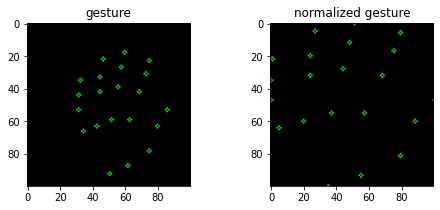

In [43]:
blank = np.zeros((100,100,3), np.uint8)
index = 1100
copy, copy_norm = np.copy(blank), np.copy(blank)
for n, m in zip(np.reshape(processed.drop(['gesture'], axis=1).iloc[[index]].values, (-1, 2)), 
                np.reshape(gesture_points.iloc[[index]].values, (-1, 2))):
    cv2.circle(copy, (int(n[0]), int(n[1])), 1, (0, 255, 0))
    cv2.circle(copy_norm, (int(m[0]*100), int(m[1]*100)), 1, (0, 255, 0))

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(copy)
axes[0].set_title('gesture')
axes[1].imshow(copy_norm)
axes[1].set_title('normalized gesture')
plt.show()

### 翻转手势

正如我们之前看到的，数据集只有右手。这意味着该模型将只能识别右手的手势。为了能够识别左手我们需要把左手的点加起来。一种方法是在图像处理部分翻转图像。但这将使处理时间增加一倍，这并不好。另一种方法是用标准化点来做。因为我们需要在 x 轴上翻转手势我们可以用点的 x 值来翻转列。这可以通过用我们想要翻转的值减去最大值来实现。

$$(1 - \text{value})$$

In [44]:
flipped_gesture_points = gesture_points.copy()
for c in flipped_gesture_points.columns.values[::2]:
    flipped_gesture_points.loc[:, c] = (1 - flipped_gesture_points.loc[:, c])
flipped_gesture_points.head(3)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.000000,1.0,0.354839,0.877551,0.709677,0.653061,0.870968,0.469388,1.000000,0.346939,...,0.645161,0.510204,0.129032,0.367347,0.419355,0.367347,0.580645,0.428571,0.580645,0.510204
1,0.434783,1.0,0.217391,0.741379,0.130435,0.482759,0.000000,0.224138,0.130435,0.086207,...,0.217391,0.172414,0.869565,0.500000,0.782609,0.137931,0.478261,0.068966,0.304348,0.189655
2,0.392857,1.0,0.535714,0.819672,0.714286,0.590164,0.142857,0.344262,0.000000,0.213115,...,0.250000,0.049180,0.321429,0.508197,0.250000,0.295082,0.250000,0.147541,0.214286,0.147541


在下面的例子中，我们可以看到两个规范化的手势。左边的图像是原始手势点。右边的图像是翻转的手势点。现在我们有了一个普通的和翻转的手势数据帧。

Text(0.5, 1.0, 'flipped gesture')

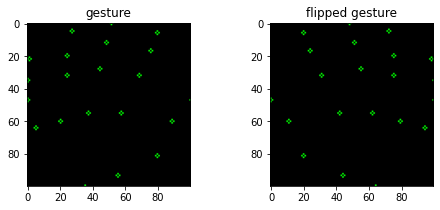

In [45]:
copy, copy_flipped = np.copy(blank), np.copy(blank)
for n, f in zip(np.reshape(gesture_points.iloc[[index]].values, (-1, 2)),  
                    np.reshape(flipped_gesture_points.iloc[[index]].values, (-1, 2))):
    cv2.circle(copy, (int(n[0]*100), int(n[1]*100)), 1, (0, 255, 0))
    cv2.circle(copy_flipped, (int(f[0]*100), int(f[1]*100)), 1, (0, 255, 0))
    
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(copy)
axes[0].set_title('gesture')
axes[1].imshow(copy_flipped)
axes[1].set_title('flipped gesture')

### 最终的 dataframe

最后，我们可以将手势点和翻转手势点相加。在第 43 栏中加上手势的含义。

In [46]:
gestures = pd.concat([gesture_points, gesture_meaning], axis=1)
reverse_gestures = pd.concat([flipped_gesture_points, gesture_meaning], axis=1)
gesture_dataframe = gestures.append(reverse_gestures, ignore_index=True)

现在数据帧已经被处理，我们可以将它保存为CSV文件，这样以后我们就可以导入数据集，而不是再次运行所有内容。

In [47]:
gesture_dataframe.to_csv('../dataframes/gesture-points-processed.csv', index=None)

In [48]:
gesture_dataframe = pd.read_csv('../dataframes/gesture-points-processed.csv')

## 建模

### 准备数据

首先，我们需要准备好数据。为了训练模型，需要一个训练和测试集。训练集用于训练模型，测试集用于验证模型。训练和测试都有一个X和y坐标系。x数据是点数据。y数据是标签数据。

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(gesture_dataframe.drop('gesture', axis=1), 
                                                    gesture_dataframe['gesture'],
                                                    test_size = 0.2, 
                                                    random_state=42)

### 选择算法

为了选择正确的算法，我们将使用 Sklearn 的这张图表。不同的算法更适合于不同类型的数据和不同的问题。所以，我们将按照这个图表。首先，我们必须检查数据集是否有超过 50 个样本，因为我们有超过 4000 行。它问我们是否在预测一个类别/标签，我们试图预测一个手势的标签/含义，所以这将是一个“是”。然后我们必须检查我们的数据是否有标签。是的，因为最后一列有手势的意思。然后，我们需要检查数据集的样本是否小于100000。最后我们得到了 'LinearSVC' 估计量。

![estimator chart](https://scikit-learn.org/stable/_static/ml_map.png)

### 训练

现在可以训练模型。从上面的图表中我们得出结论，linearSVC 最适合这个数据集。因此，可以用训练集来训练模型。然后用测试数据集对模型进行评分。

In [50]:
from sklearn.svm import SVC
import time

start = time.time()
#Training model
svm_model = SVC(kernel='poly', random_state=42, C=1.0, probability=True)
svm_model.fit(X_train, y_train)

#Calculating elapsed time
stop = time.time()
elapsed_time = ((stop - start) / 60)
print('Training time: {} minutes and {} seconds'
.format(int(elapsed_time), int(((elapsed_time % 1) * 60))))
    
#Calculating score
print('Score:',svm_model.score(X_test, y_test).round(2))

Training time: 0 minutes and 0 seconds
Score: 0.95


### 验证

为了可视化模型的预成形，可以创建一个混淆矩阵。矩阵的每一行代表一个预测值，而每一列是实际值中的实例。

所有标签的得分都高于 0.9。还有一个手势是模特得1分。这可能意味着这个手势与数据过于匹配。但我认为它不是，因为数据集有很多不同的图像。从这个矩阵可以假设模型能够清楚地分离每个手势。

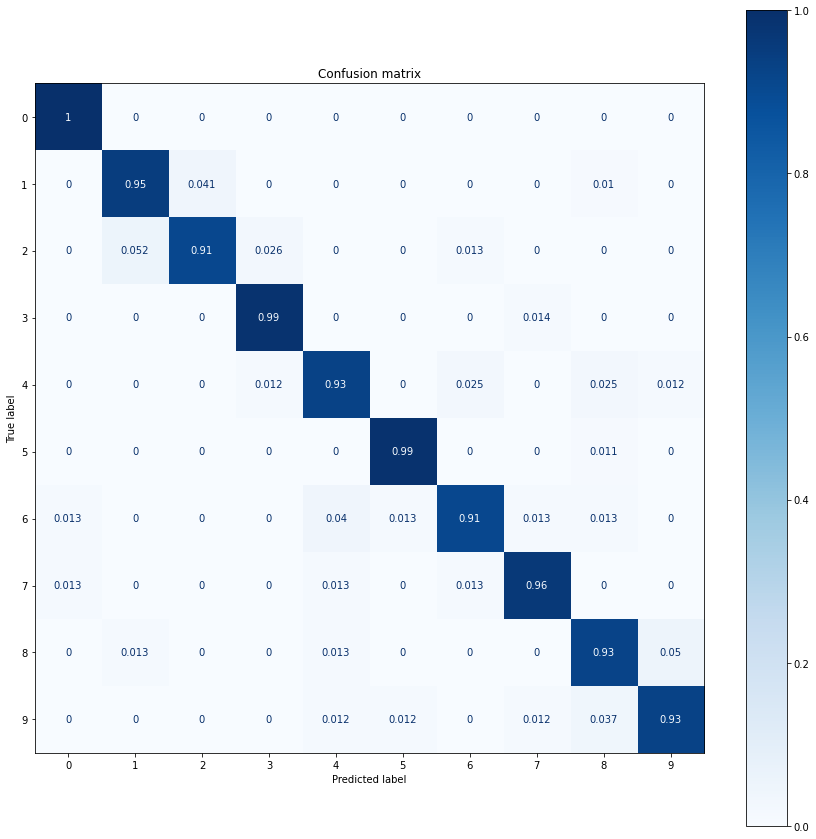

In [51]:
from sklearn.metrics import plot_confusion_matrix

# creating confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
matrix = plot_confusion_matrix(svm_model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 ax=ax)

# plot the matrix
plt.title('Confusion matrix')
plt.show(matrix)

### 测试

最后，可以用之前没有见过的图像来测试模型。对于这个测试，我们将使用 Mediapipe 而不是 OpenCV。这是因为 Mediapipe 的手模型比使用手姿势模型要快得多。使用这个模型的另一个原因是，它能够在一个图像中识别多个手。用于测试数据位于 `test_images/` 文件夹中。这个文件夹包含 20 张图片，每个手势两个。每个手势都有一个左手和右手的图像来测试模型是否可以预测双手。对于每个图像，一个图形是创建与每个手势标签的置信度。标准越高，模型越确信自己是正确的标签。当然，具有最高置信度的标签将被视为预测的标签。

In [53]:
from mediapipe.python.solutions import drawing_utils, hands
from pathlib import Path

# load the mediapipe hand model
hand_model = hands.Hands(static_image_mode=True)

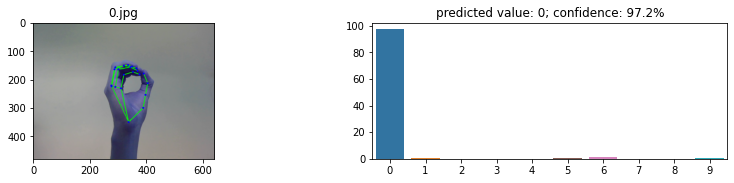

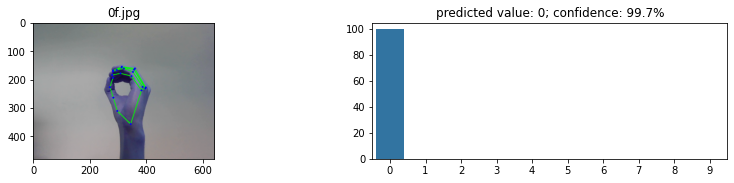

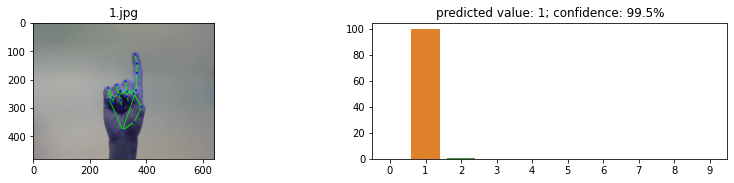

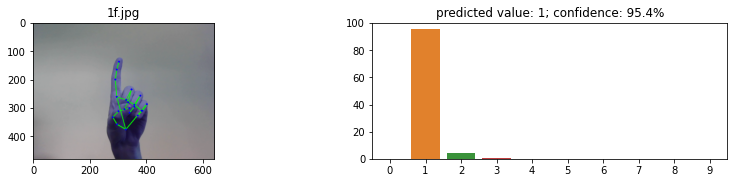

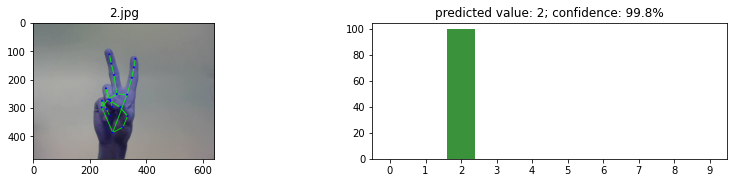

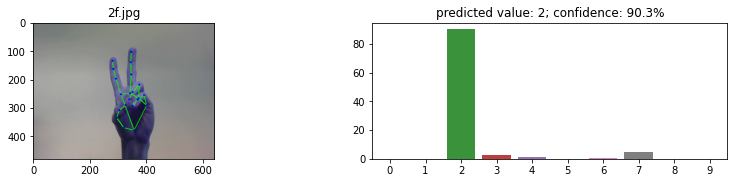

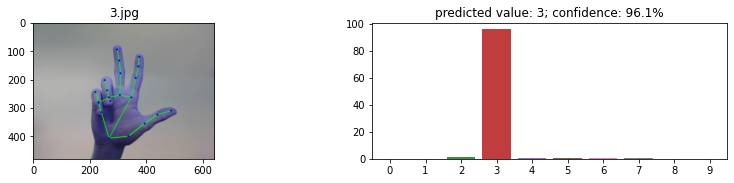

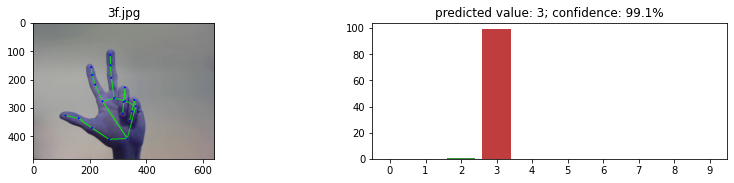

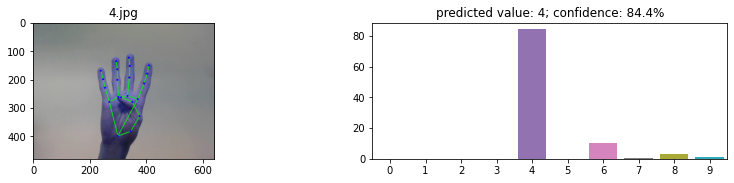

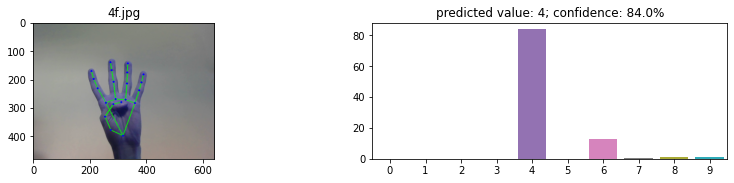

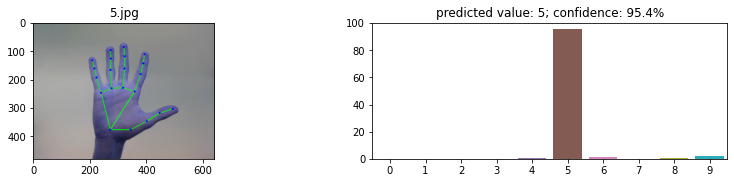

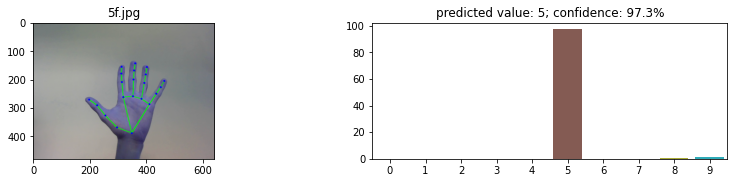

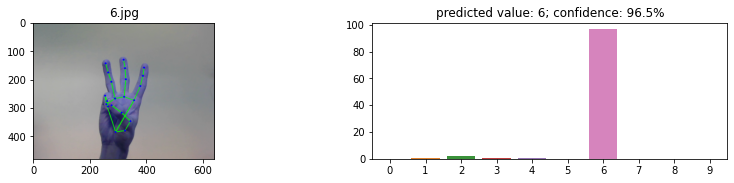

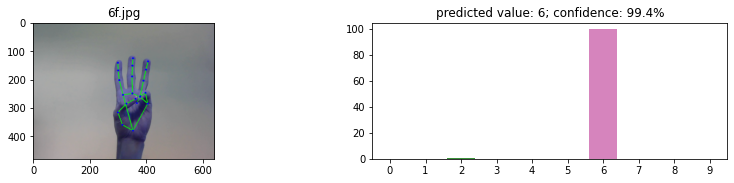

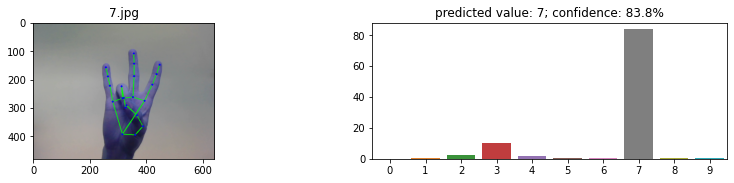

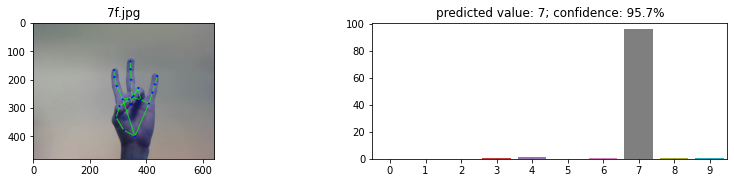

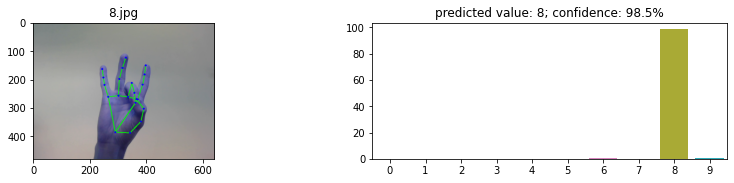

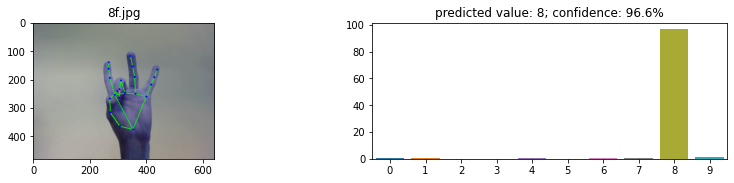

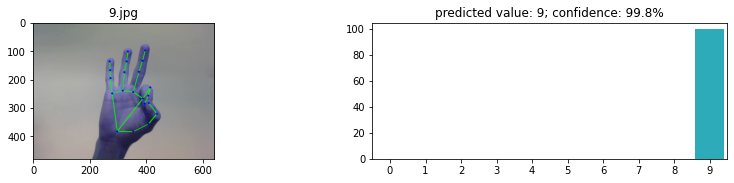

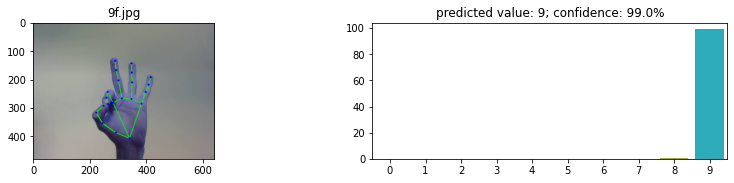

In [62]:
root = '../test_images'
# 循环遍历test文件夹中的每个图像
for path in Path(root).iterdir():
    example_im = cv2.imread(path.as_posix())
    # 获得手模型的预测
    results = hand_model.process(cv2.cvtColor(example_im, cv2.COLOR_BGR2RGB))
    # 在图像上绘制骨架
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0]
        drawing_utils.draw_landmarks(
            example_im, landmarks, hands.HAND_CONNECTIONS)

        # 从预测中得到x和y的值
        x, y = [], []
        for lm in landmarks.landmark:
            x.append(lm.x)
            y.append(lm.y)

        # 标准化点
        points = np.asarray([x, y])
        min = points.min(axis=1, keepdims=True)
        max = points.max(axis=1, keepdims=True)
        normalized = np.stack((points-min)/(max-min), axis=1).flatten()
        # 从手势模型中获得预测
        pred = svm_model.predict_proba([normalized])

        # 获得手势预测和置信度
        gesture = pred.argmax(axis=1)[0]
        confidence = pred.max()

        # 显示图像并绘制图形
        fig, axes = plt.subplots(1, 2, figsize=(14, 2.5))
        axes[0].imshow(example_im, cmap=plt.cm.gray)
        axes[0].set_title(path.name)
        sns.barplot(y=(pred[0] * 100), x=np.arange(10))
        axes[1].set_title(
            f'predicted value: {gesture}; confidence: {confidence:.1%}')

这次试验的结果相当成功。所有的测试图像都得到了正确的预测，置信度从未低于 80%。信任度最低的手势是“4”，左手和右手的信任度都在 84% 左右。对于剩下的所有图像，左手和右手之间的置信度是非常相似的。

## 导出模型

现在我们已经创建了一个成功的模型，我们可以导出它了。通过 [joblib](https://joblib.readthedocs.io/en/latest/) 包，我们可以将模型导出为`pickle`。Pickle 是 Python 对象的序列化和反序列化协议。稍后，我们可以通过使用 `joblib` 包加载模型来再次使用模型。

In [63]:
import joblib

joblib.dump(svm_model, '../model/gesture_model.pkl', compress=9)

['../model/gesture_model.pkl']